# Introduction

We'll be working to create a movie recommendation system on behalf of Moviefy, a new streaming video competitor. A solution to boredom and overwhelming choice, this new platform will be entirely based on our recommender system, eliminating the ability to search for titles at all.

We will rely on data from https://grouplens.org/datasets/movielens/latest/. We will use RMSE to determine our best fit model. Models will be created using the surprise library and ALS spark.


# Import Packages & Data

In [59]:
import pandas as pd 
import numpy as np
from scipy import sparse 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise import Reader, Dataset
from surprise import accuracy


from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline
from surprise.prediction_algorithms import KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
#For reproducibility

import random
import numpy as np

my_seed = 24
random.seed(my_seed)
np.random.seed(my_seed)

In [61]:
# Creating dataframes of all needed CSV files
links  = pd.read_csv('ml-latest-small/links.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

# EDA

## Brief EDA of each DF

In [62]:
links.head()
#Movie ID with links to IDs for IMDB and TMDB

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [63]:
ratings.head()
#most useful for modeling. Includes user id,movie id, rating 

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [64]:
movies.head()

#Helpful for making actual recommendations. Includes titles and genres

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [65]:
tags.head()

#Movie ID and tag. Helpful for identifying trends among recommendations

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## Combining dataframes

In [66]:
#Combining ratings and movies dataframes for easier recommendations later

combined_df = ratings.merge(movies,how='left', left_on='movieId', right_on='movieId')
combined_df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [67]:
#Drop Timestamp
combined_df = combined_df.drop('timestamp',axis=1)
combined_df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


## User Info

In [68]:
#610 unique users

len(combined_df.userId.unique())

610

In [69]:
#Average user has rated ~165 movies

combined_df.userId.value_counts().mean()

165.30491803278687

## Movie/Ratings Info

In [70]:
#Unique Movies

len(combined_df.movieId.unique())

9724

In [71]:
#dverage rating 3.5 with a maximum movie rating of 5.0

combined_df['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Text(0, 0.5, 'Movie Count')

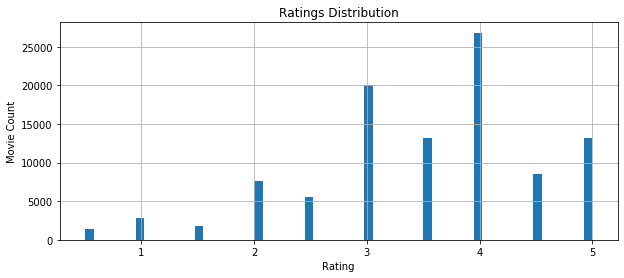

In [72]:
# Most movies get between 3 and 4 stars
plt.figure(figsize=(10,4))
combined_df['rating'].hist(bins=60)
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Movie Count")

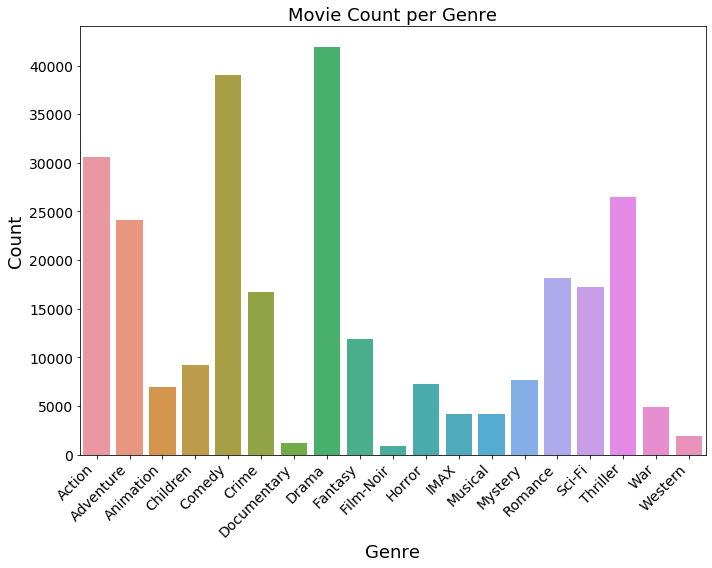

In [73]:
from sklearn.preprocessing import MultiLabelBinarizer

movie_genres = combined_df['genres'].str.split('|')
movie_genres

mlb = MultiLabelBinarizer()
genres_ohe = pd.DataFrame(mlb.fit_transform(movie_genres),
                   columns=mlb.classes_,
                   index=movie_genres.index)
genres_ohe = genres_ohe.drop('(no genres listed)', axis = 1)
genre_count = list(genres_ohe.sum())
genre_list = list(genres_ohe.columns.values)


plt.figure(figsize=(10,8))
sns.barplot(x = genre_list, y = genre_count)
plt.title('Movie Count per Genre', fontsize = 18)
plt.xticks(rotation = 45, fontsize = 14, horizontalalignment="right")
plt.xlabel('Genre', fontsize = 18)
plt.yticks(fontsize = 14)
plt.ylabel('Count', fontsize = 18)
plt.tight_layout()

### Top Rated Movies (All Movies)

In [74]:
top_movies =  combined_df[['title','rating']]
top_movies

,title,rating
0,Toy Story (1995),4.0
1,Grumpier Old Men (1995),4.0
2,Heat (1995),4.0
3,Seven (a.k.a. Se7en) (1995),5.0
4,"Usual Suspects, The (1995)",5.0
...,...,...
100831,Split (2017),4.0
100832,John Wick: Chapter Two (2017),5.0
100833,Get Out (2017),5.0
100834,Logan (2017),5.0


In [75]:
top_movies = top_movies.groupby('title',as_index=False).mean()
top_movies.head()

,title,rating
0,'71 (2014),4.0
1,'Hellboy': The Seeds of Creation (2004),4.0
2,'Round Midnight (1986),3.5
3,'Salem's Lot (2004),5.0
4,'Til There Was You (1997),4.0


In [76]:
#Top 10 movies (all)
top_movies.sort_values('rating',ascending=False)[:10]

,title,rating
3354,Gena the Crocodile (1969),5.0
8951,True Stories (1986),5.0
1986,Cosmic Scrat-tastrophe (2015),5.0
5269,Love and Pigeons (1985),5.0
7033,Red Sorghum (Hong gao liang) (1987),5.0
8661,"Thin Line Between Love and Hate, A (1996)",5.0
5019,Lesson Faust (1994),5.0
2799,Eva (2011),5.0
9435,Who Killed Chea Vichea? (2010),5.0
7662,Siam Sunset (1999),5.0


In [77]:
#Top 10 movies are all rated 5 stars...
#let's see what the top 10 movies looks like for movies with more than 1 rating 
#inferring that these movies are less popular

### Top 10 Movies - Most frequently rated

In [78]:
rating_frequency = pd.DataFrame(combined_df.title.value_counts(sort=True,ascending=False))
rating_frequency.reset_index(inplace=True)   
rating_frequency.rename(columns={"index": "title", "title": "frequency"},inplace=True)
rating_frequency.head()

,title,frequency
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278


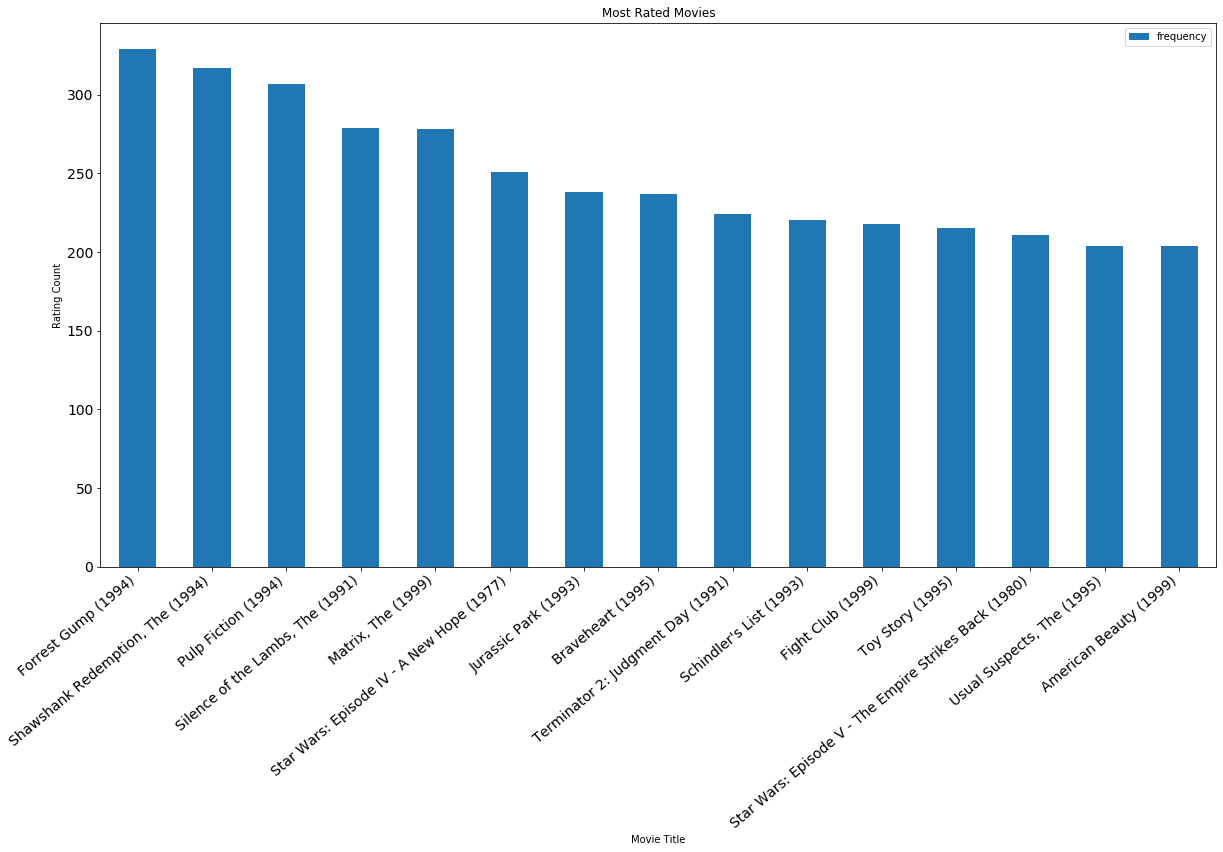

<Figure size 432x288 with 0 Axes>

In [79]:
# Top 25 most rated movies
rating_frequency[:15].plot(kind='bar',x = 'title',y = 'frequency',figsize=(20,10))
plt.title("Most Rated Movies")
plt.xlabel("Movie Title")
plt.xticks(rotation=40,fontsize = 14, horizontalalignment="right")
plt.ylabel("Rating Count")
plt.yticks(fontsize = 14)
plt.show()
plt.tight_layout()

In [80]:
#average number of times movies are rated

mean_frequency = rating_frequency.frequency.mean()
mean_frequency

10.375141475460438

In [81]:
rated_titles = list(rating_frequency.title[rating_frequency.frequency >= mean_frequency])

In [82]:
#Top 10 movies (more popular)

rated_movies = top_movies[top_movies.title.isin(rated_titles)]
rated_movies.sort_values('rating',ascending=False)[:10]

,title,rating
7486,Secrets & Lies (1996),4.590909
3672,Guess Who's Coming to Dinner (1967),4.545455
6505,Paths of Glory (1957),4.541667
8110,"Streetcar Named Desire, A (1951)",4.475000
1641,"Celebration, The (Festen) (1998)",4.458333
6964,Ran (1985),4.433333
7593,"Shawshank Redemption, The (1994)",4.429022
3953,His Girl Friday (1940),4.392857
8163,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.333333
4152,"Hustler, The (1961)",4.333333


### Most Rated Movies - Can Infer That These Were Likely The Most Watched

In [83]:
#may be popularity bias

rating_frequency[:10]

,title,frequency
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278
5,Star Wars: Episode IV - A New Hope (1977),251
6,Jurassic Park (1993),238
7,Braveheart (1995),237
8,Terminator 2: Judgment Day (1991),224
9,Schindler's List (1993),220


In [84]:
rating_frequency.describe()

,frequency
count,9719.000000
mean,10.375141
std,22.406220
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,329.000000


# Modeling

### Preparing for Modelling

In [85]:
#Prepping for surprise

ratings = ratings.drop('timestamp',axis=1)
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [86]:
#Converting to something compatible with surprise

reader = Reader()
data = Dataset.load_from_df(ratings,reader)

In [87]:
#We'll use a user-based system, given that there are fewer unique users.
#less computationally expensive

print('Number of users: ', len(ratings.userId.unique()), '\n')
print('Number of items: ', len(ratings.movieId.unique()))

Number of users:  610 

Number of items:  9724


### Train-Test Split

In [88]:
train, test = train_test_split(data, test_size=.2)

### Execution Formula

In [89]:
#dataframe to same RMSEs for later comparison

all_models = pd.DataFrame(columns=['Model','RMSE'])

In [90]:
#formula to quickly run models

def execute(model_name,model,train_set,test_set):
    
    #Fitting model
    
    model.fit(train_set)
    
    #RMSE values
    
    predictions = model.test(test_set)
    RMSE = accuracy.rmse(predictions)
    
    #Saving values
    
    results = {'Model': model_name}
    results['RMSE'] = RMSE
    
    return results

### Baseline Model

In [91]:
model_name = 'Baseline'
model = BaselineOnly(bsl_options={'user_based':True})
baseline_results = execute(model_name,model,train,test)
baseline_df = pd.DataFrame([baseline_results], columns=baseline_results.keys())
all_models = all_models.append(baseline_df)

Estimating biases using als...
RMSE: 0.8762


### NormalPredictor

In [92]:
model_name = 'Normal Predictor'
model = NormalPredictor()
normal_predictor_results = execute(model_name,model,train,test)
normal_predictor_df = pd.DataFrame([normal_predictor_results], columns=normal_predictor_results.keys())
all_models = all_models.append(normal_predictor_df)

RMSE: 1.4301


### KNN Basic

In [93]:
model_name = 'KNN Basic'
model = KNNBasic(sim_options={'user_based': True})
KNNBasic_results = execute(model_name,model,train,test)
KNNBasic_df = pd.DataFrame([KNNBasic_results], columns=KNNBasic_results.keys())
all_models = all_models.append(KNNBasic_df)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9495


### KNN with Means

In [94]:
model_name = 'KNN with Means'
model = KNNWithMeans(sim_options={'user_based': True})
KNNWithMeans_results = execute(model_name,model,train,test)
KNNWithMeans_df = pd.DataFrame([KNNWithMeans_results], columns=KNNWithMeans_results.keys())
all_models = all_models.append(KNNWithMeans_df)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9010


### KNN with Z-Score

In [95]:
model_name = 'KNN with Z-Score'
model = KNNWithZScore(sim_options={'user_based': True})
KNNwithZscore_results = execute(model_name,model,train,test)
KNNBasic_df = pd.DataFrame([KNNwithZscore_results], columns=KNNwithZscore_results.keys())
all_models = all_models.append(KNNBasic_df)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8996


### KNN Baseline

In [96]:
model_name = 'KNN Baseline'
model = KNNBaseline(sim_options={'user_based': True})
KNNBaseline_results = execute(model_name,model,train,test)
KNNBaseline_df = pd.DataFrame([KNNBaseline_results], columns=KNNBaseline_results.keys())
all_models = all_models.append(KNNBaseline_df)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8783


### SVD

In [97]:
model_name = 'SVD'
model = SVD()
SVD_results = execute(model_name,model,train,test)
SVD_df = pd.DataFrame([SVD_results], columns=SVD_results.keys())
all_models = all_models.append(SVD_df)

RMSE: 0.8783


### SVDpp

In [98]:
model_name = 'SVDpp'
model = SVDpp()
SVDpp_results = execute(model_name,model,train,test)
SVDpp_df = pd.DataFrame([SVDpp_results], columns=SVDpp_results.keys())
all_models = all_models.append(SVDpp_df)

RMSE: 0.8619


### NMF

In [99]:
model_name = 'NMF'
model = NMF()
NMF_results = execute(model_name,model,train,test)
NMF_df = pd.DataFrame([NMF_results], columns=NMF_results.keys())
all_models = all_models.append(NMF_df)

RMSE: 0.9239


### SlopeOne

In [100]:
model_name = 'Slope One'
model = SlopeOne()
SlopeOne_results = execute(model_name,model,train,test)
SlopeOne_df = pd.DataFrame([SlopeOne_results], columns=SlopeOne_results.keys())
all_models = all_models.append(SlopeOne_df)

RMSE: 0.9051


### Co-Clustering

In [101]:
model_name = 'Co-Clustering'
model = CoClustering()
CoClustering_results = execute(model_name,model,train,test)
CoClustering_df = pd.DataFrame([CoClustering_results], columns=CoClustering_results.keys())
all_models = all_models.append(CoClustering_df)

RMSE: 0.9482


### Results

In [102]:
all_models.sort_values(by='RMSE',ascending=True)

,Model,RMSE
0,SVDpp,0.861879
0,Baseline,0.876181
0,SVD,0.878338
0,KNN Baseline,0.878345
0,KNN with Z-Score,0.899625
0,KNN with Means,0.900986
0,Slope One,0.905059
0,NMF,0.923854
0,Co-Clustering,0.948221
0,KNN Basic,0.949513


In [103]:
#We'll move forward by refining the top 3 models. SVDpp, SVD and Baseline

In [104]:
#See Project-Part 2 notebook for further steps. 

# Exporting for Later Use

In [105]:
all_models.to_csv('all_models',index=False)

In [106]:
ratings.to_csv('ratings',index=False)

In [107]:
combined_df.to_csv('movies_info',index=False)